## Prompt Metadata

#### Metadata File to pandas dataframe

In [1]:
from src.utils import read_yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
metadata = read_yaml("prompt-metadata/anli1.yaml")

In [3]:
# flatten metadata and convert to dataframe
metadata = {k: {**v['costs'], **v['characteristics'], **v['performance']} for k, v in metadata.items()}
meta_df = pd.DataFrame.from_dict(metadata, orient='index')

#### Add PALM FewShot performance to metadata

In [4]:
from src.factories import dataLoaderFactory, teacherResponseParserFactory
from src.teacher_response_evaluator import TeacherResponseEvaluator

c:\Projects\master-thesis\ZeroShot-step-by-step-distillation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load PALM predictions and rationales
dataset_loader = dataLoaderFactory("anli1")
train_llm_rationales, train_llm_labels = dataset_loader.load_llm_preds(split="train")

parsed_responses = {i: (label, rational) for i, (label, rational) in enumerate(zip(train_llm_labels, train_llm_rationales))}

In [6]:
evaluator = TeacherResponseEvaluator("anli1")

label_eval = evaluator.get_label_accuracy(split="train", parsed_responses=parsed_responses)
rationale_eval = evaluator.get_explanation_characteristics(parsed_responses=parsed_responses)

In [7]:
palm_eval = {"accuracy": label_eval[0],
             "n_correct": label_eval[1],
             "n_wrong": label_eval[2],
             "n_none_responses": rationale_eval[0],
             "total_responses": rationale_eval[1],
             "total_length_of_explanations": rationale_eval[2],
             "total_number_of_sentences": rationale_eval[3],
             "total_number_of_words": rationale_eval[4],
             "flesch_reading_ease": rationale_eval[5],
             "avg_len_of_explanations": rationale_eval[2] / rationale_eval[1],
             "avg_nr_of_sentences": rationale_eval[3] / rationale_eval[1],
             "avg_nr_of_words": rationale_eval[4] / rationale_eval[1],
             "n_parse_errors": 0,
             }


In [8]:
# insert PALM evaluation into metadata dataframe with index 0
meta_df = pd.concat([pd.DataFrame(palm_eval, index=[0]), meta_df])

#### Add derived features to metadata

In [9]:
# add column with explanation rate = total responses / (n_correct + n_wrong)
meta_df["explanation_rate"] = meta_df["total_responses"] / (meta_df["n_correct"] + meta_df["n_wrong"])

In [10]:
meta_df.head()

,accuracy,n_correct,n_wrong,n_none_responses,total_responses,total_length_of_explanations,total_number_of_sentences,total_number_of_words,flesch_reading_ease,avg_len_of_explanations,...,avg_nr_of_words,n_parse_errors,avg_cost_per_query,avg_nr_tokens_received,avg_nr_tokens_sent,total_accumulated_costs,total_performed_queries,total_tokens_received,total_tokens_sent,explanation_rate
0,0.709076,12016,4930,0,16946,1925445,25264,326230,63.22534,113.622389,...,19.251151,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00
1,0.592000,74,51,0,125,15470,130,2583,47.30000,123.760000,...,20.660000,0,0.00020,30.08,125.28,0.025320,125.0,3760.0,15660.0,1.00
2,0.456000,57,68,0,125,21123,137,3396,40.80000,168.980000,...,27.170000,0,0.00033,40.82,215.10,0.041242,125.0,5103.0,26887.0,1.00
3,0.576000,72,53,125,0,0,0,0,0.00000,0.000000,...,0.000000,0,0.00015,2.78,123.28,0.019296,125.0,347.0,15410.0,0.00
4,0.600000,30,20,2,48,15915,140,2580,46.50000,331.560000,...,53.750000,1,0.00037,89.04,126.84,0.018417,50.0,4452.0,6342.0,0.96


## Plots

Text(0.5, 1.0, 'Explanation Rate')

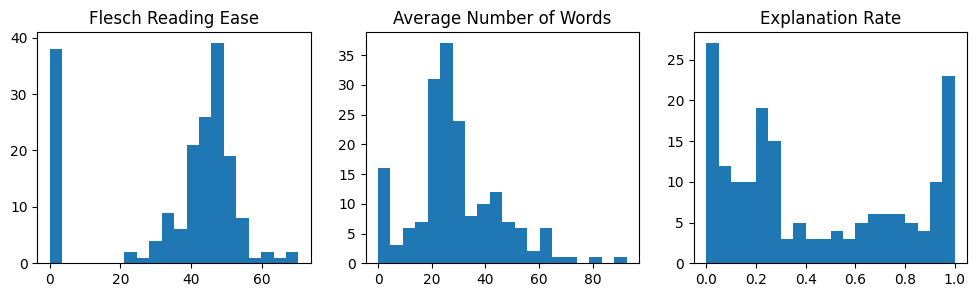

In [11]:
# histograms of: flesh reading ease, avg_nr_of_sentences, avg_nr_of_words
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
ax1.hist(meta_df["flesch_reading_ease"], bins=20)
ax1.set_title("Flesch Reading Ease")
ax2.hist(meta_df["avg_nr_of_words"], bins=20)
ax2.set_title("Average Number of Words")
ax3.hist(meta_df["explanation_rate"], bins=20)
ax3.set_title("Explanation Rate")

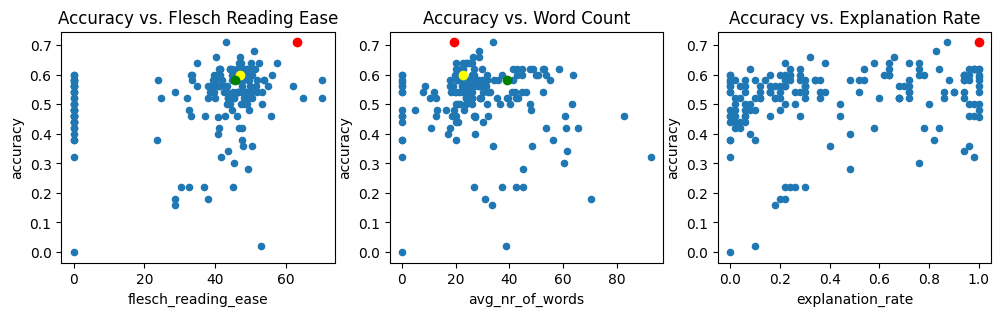

In [12]:
# scatter plots of accuracy vs. flesch reading ease alongside accuracy vs. word count, alongside acc vs. n_responses
# collor point with index 0 red to indicate PALM
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
meta_df.plot.scatter(x="flesch_reading_ease", y="accuracy", title="Accuracy vs. Flesch Reading Ease", ax=ax1)
meta_df.plot.scatter(x="avg_nr_of_words", y="accuracy", title="Accuracy vs. Word Count", ax=ax2)
meta_df.plot.scatter(x="explanation_rate", y="accuracy", title="Accuracy vs. Explanation Rate", ax=ax3)
ax1.scatter(meta_df.iloc[0]['flesch_reading_ease'], meta_df.iloc[0]['accuracy'], color='red')
ax1.scatter(meta_df.iloc[178]['flesch_reading_ease'], meta_df.iloc[178]['accuracy'], color='yellow') # explain to me like i'm 5
ax1.scatter(meta_df.iloc[177]['flesch_reading_ease'], meta_df.iloc[177]['accuracy'], color='green') # explain to me like i'm 5
ax2.scatter(meta_df.iloc[0]['avg_nr_of_words'], meta_df.iloc[0]['accuracy'], color='red')
ax2.scatter(meta_df.iloc[178]['avg_nr_of_words'], meta_df.iloc[178]['accuracy'], color='yellow') # explain to me like i'm 5
ax2.scatter(meta_df.iloc[175]['avg_nr_of_words'], meta_df.iloc[175]['accuracy'], color='green') # explain to me like i'm 5
ax3.scatter(meta_df.iloc[0]['explanation_rate'], meta_df.iloc[0]['accuracy'], color='red')

Good prompts, that deliver the most accurate results, seem to produce short (between 20 and 30 words), high FRE (above 45) explanations.

There seem to be the following tendencies:
 - The lower the FRE, the lower the accuracy. So complicated explanations are not good for the prediction.
 - The longer the explanation, the lower the accuracy. So long explanations are not good for the prediction.
 - However, very short explanations (< 20 words) are also not good for the prediction.
 - Wether a prompt makes the model return an explanation at all, does not seem to have an influence on the accuracy.

<Axes: title={'center': 'Parse Errors vs. Explanation Rate'}, xlabel='explanation_rate', ylabel='n_parse_errors'>

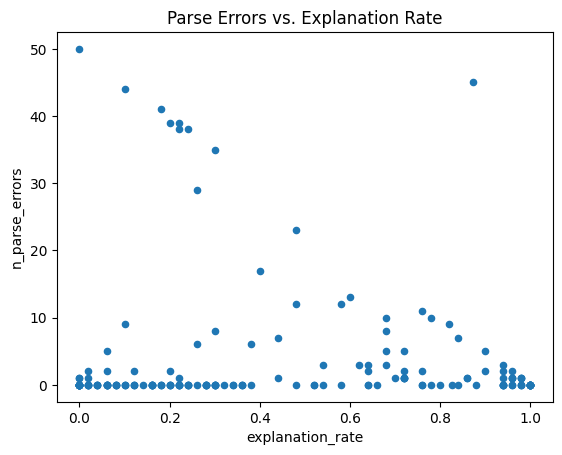

In [13]:
meta_df.plot.scatter(x="explanation_rate", y="n_parse_errors", title="Parse Errors vs. Explanation Rate")

<Axes: title={'center': 'Accuracy vs. Index'}>

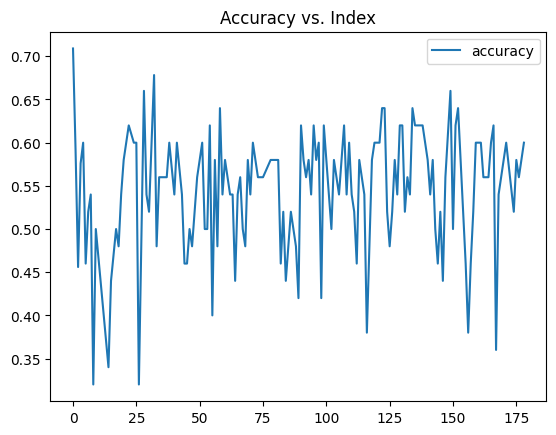

In [14]:
# line plot of accuracy vs index, filtered by n_parse_errors < 10
meta_df[meta_df["n_parse_errors"] < 5].plot.line(y="accuracy", title="Accuracy vs. Index")

<Axes: title={'center': 'Max Accuracy vs. Index'}>

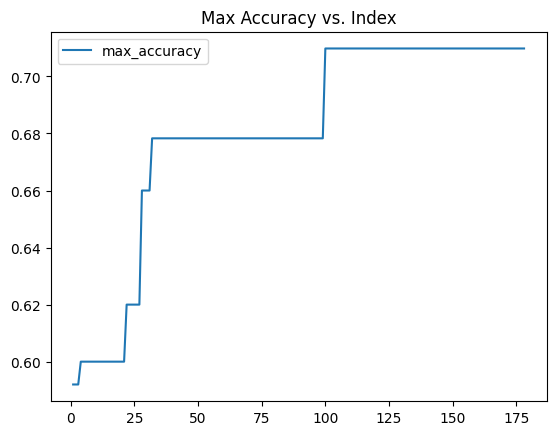

In [15]:
# line plot showing max accuracy so far vs. index, starting from index 1
meta_df["max_accuracy"] = meta_df.drop(0, axis=0)["accuracy"].cummax()
meta_df.plot.line(y="max_accuracy", title="Max Accuracy vs. Index")